## Задание  
Реализовать синтезирование лиц из LFW с помощью DCGAN  
Библиотеки: [Python, Tensorflow]

## Переключение версии TensorFlow

In [1]:
if 0:
    %tensorflow_version 2.x

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка и подготовка датасета LFW

In [3]:
train_ds, ds_info = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=True,
    split='train',
)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    full_name='lfw/0.1.0',
    description="""
    Labeled Faces in the Wild:
            A Database for Studying Face Recognition in
            Unconstrained Environments
    """,
    homepage='http://vis-www.cs.umass.edu/lfw',
    data_path='~\\tensorflow_datasets\\lfw\\0.1.0',
    file_format=tfrecord,
    download_size=172.20 MiB,
    dataset_size=180.28 MiB,
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('label', 'image'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=13233, num_shards=2>,
    },
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts,

## Подготовка пайплайна данных

In [5]:
def preprocess(label, image):
    return label, (tf.cast(image, tf.float32) - 127.5) / 127.5

In [6]:
INPUT_DIM = 512
NUM_EPOCHS = 2
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0005

In [7]:
train_ds = train_ds.map(preprocess)
train_ds = train_ds.shuffle(buffer_size=len(train_ds), seed=42)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

## Визуализация датасета LFW

In [8]:
def plot_images(images):
    fig = plt.figure(figsize=(20, 20))
    num = images.shape[0]
    for j in range(num):
        ax = fig.add_subplot(4, 4, j+1)
        ax.imshow(tf.cast((images[j].reshape(250,250,3) * 127.5) + 127.5, tf.uint8))
        plt.xticks([]), plt.yticks([])
    plt.show()

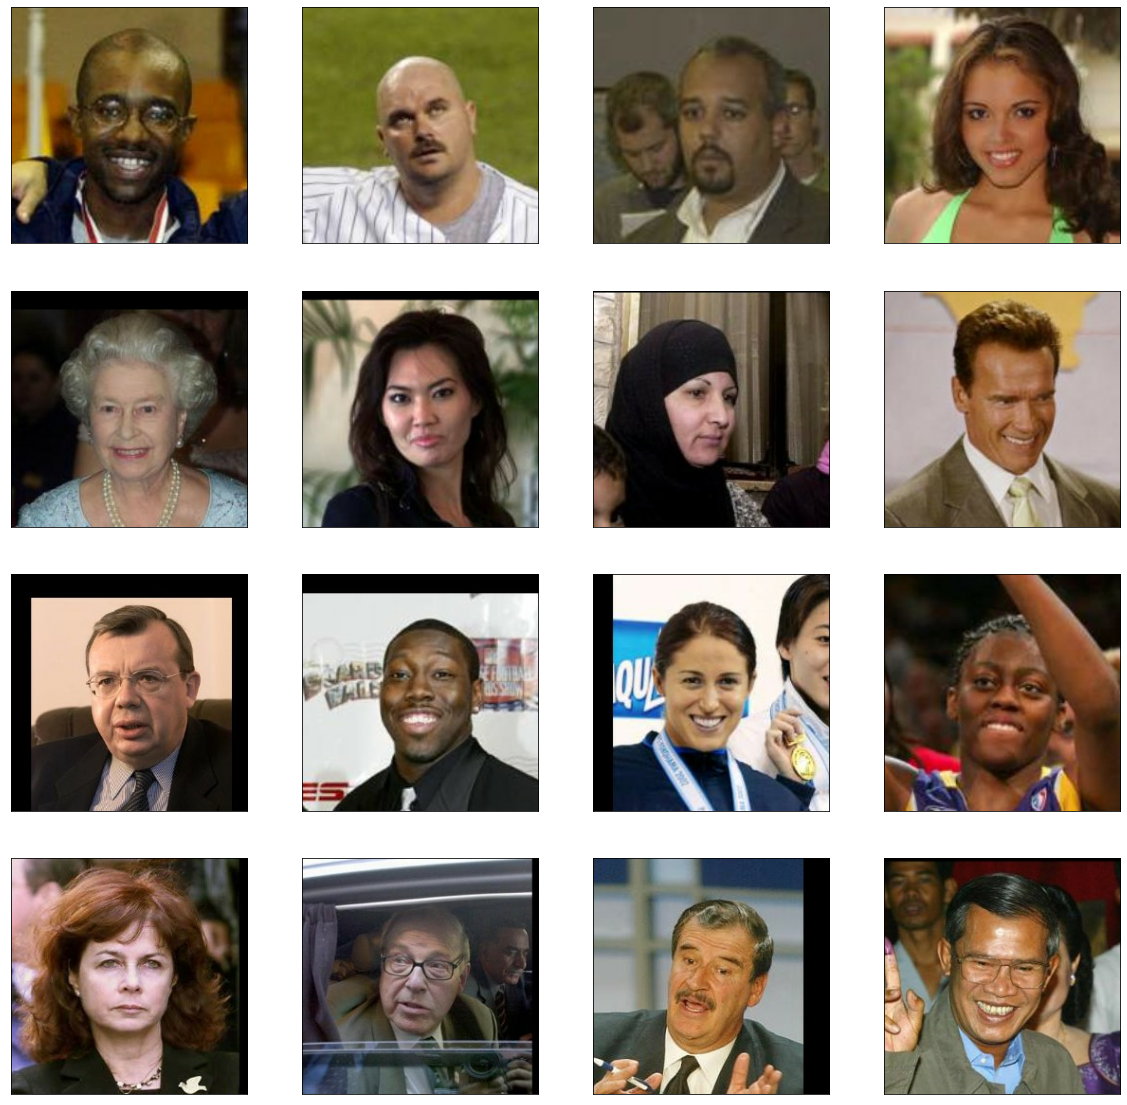

In [9]:
some_samples = next(iter(train_ds))
images = some_samples[1].numpy()
plot_images(images)

In [10]:
print(np.min(images), np.max(images))

-1.0 1.0


In [11]:
images.shape

(16, 250, 250, 3)

## Deep Convolutional GAN (DCGAN)

In [12]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(128*64*64, activation='relu'),
    tf.keras.layers.Reshape((64, 64, 128)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='valid'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(64, (3, 3), padding='valid'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

In [13]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

[Step  0] D Loss: 0.8859; G Loss: 0.1829
1/1 [==============================] - 2s 2s/step


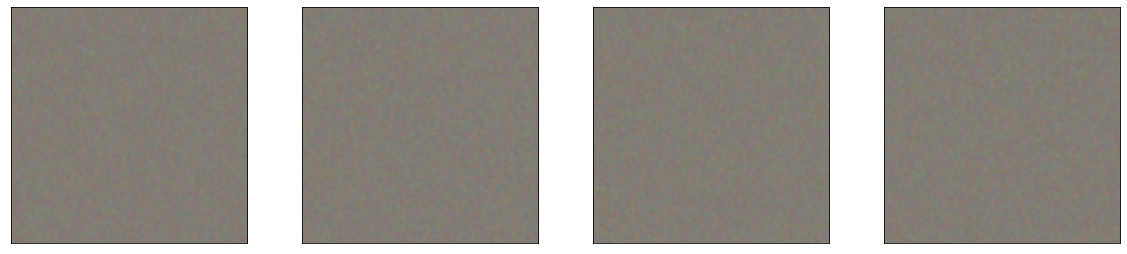

[Step 200] D Loss: 0.0000; G Loss: 125.8685
1/1 [==============================] - 1s 1s/step


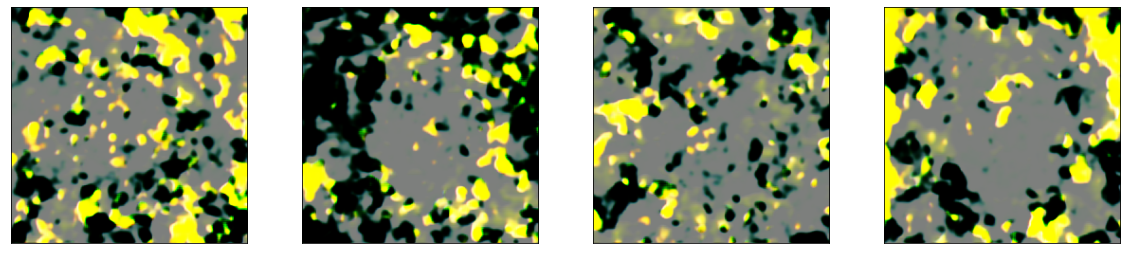

[Step 400] D Loss: 2.8341; G Loss: 19.4427
1/1 [==============================] - 1s 1s/step


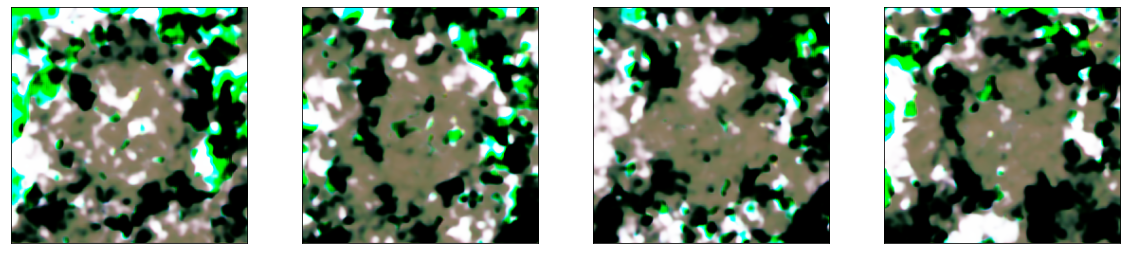

[Step 600] D Loss: 0.0000; G Loss: 14.3029
1/1 [==============================] - 1s 1s/step


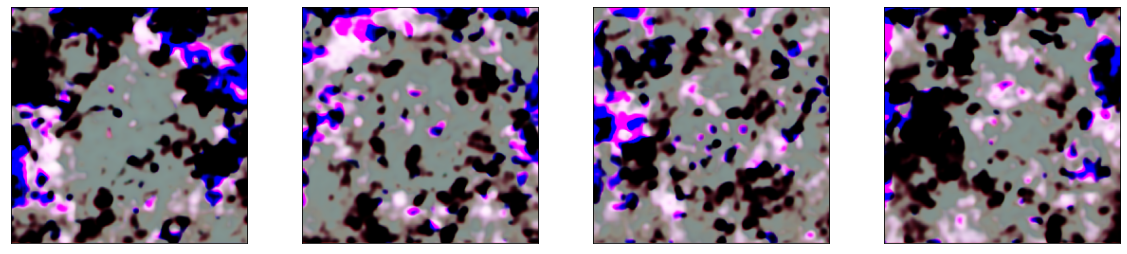

[Step 800] D Loss: 2.8018; G Loss: 11.3552
1/1 [==============================] - 1s 1s/step


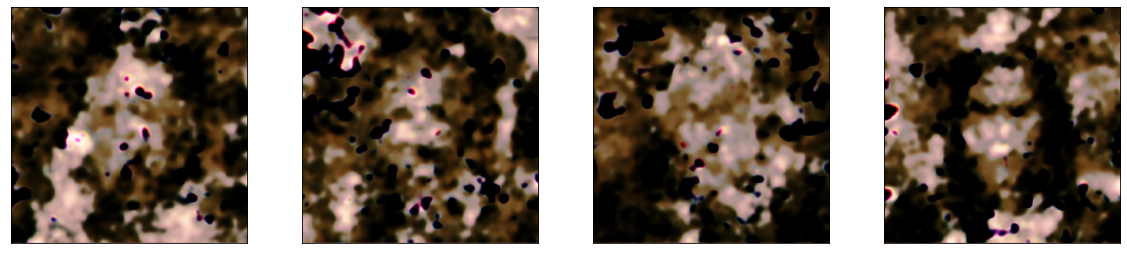

[Step 1000] D Loss: 0.8463; G Loss: 28.4779
1/1 [==============================] - 1s 1s/step


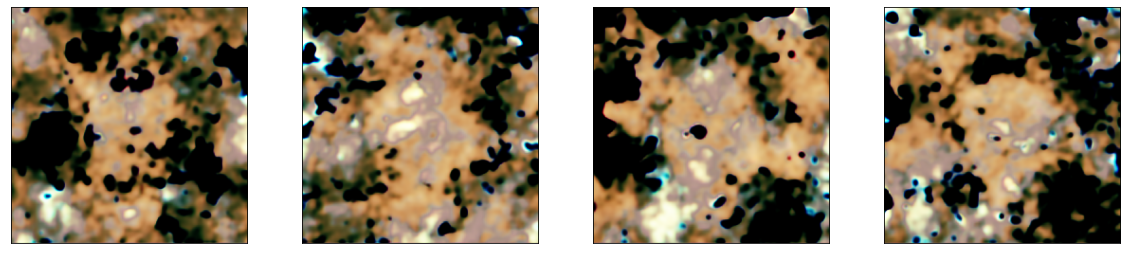

[Step 1200] D Loss: 0.1480; G Loss: 7.1900
1/1 [==============================] - 1s 1s/step


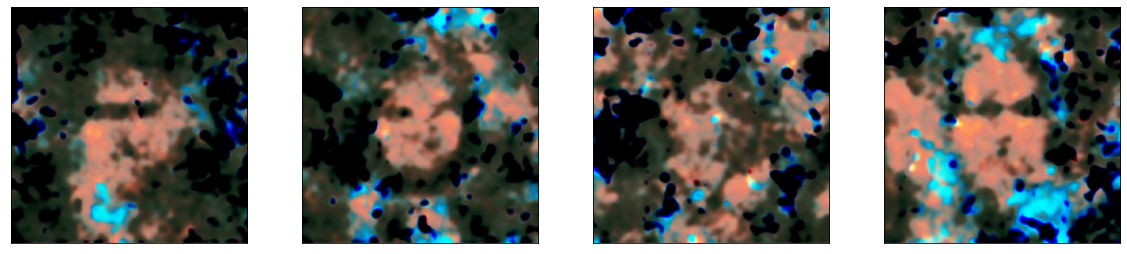

[Step 1400] D Loss: 0.7503; G Loss: 3.3244
1/1 [==============================] - 1s 1s/step


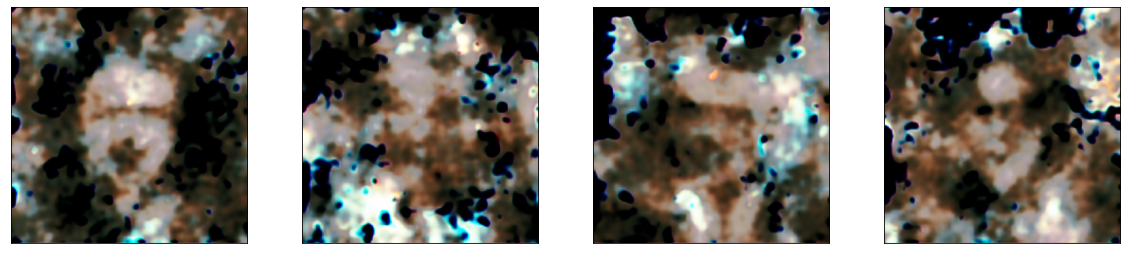

[Step 1600] D Loss: 0.4959; G Loss: 29.9044
1/1 [==============================] - 1s 1s/step


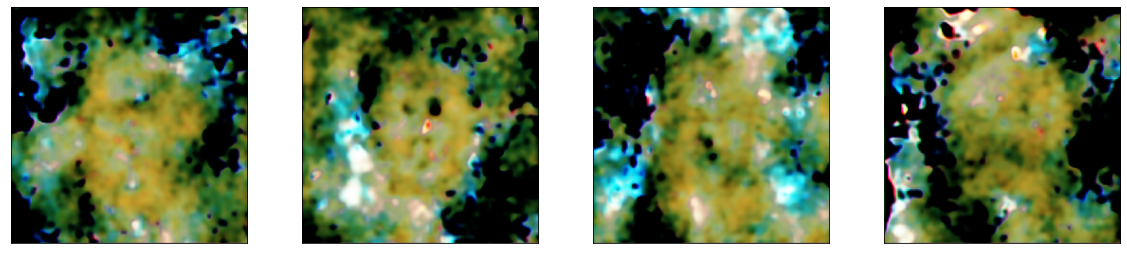

In [14]:
for step, batch in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise, verbose=False)
    x_combined = np.concatenate((
        batch[1], 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 200 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (4, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_images(syntetic_images)

## Тестирование свёрточного генератора

1/1 [==============================] - 5s 5s/step


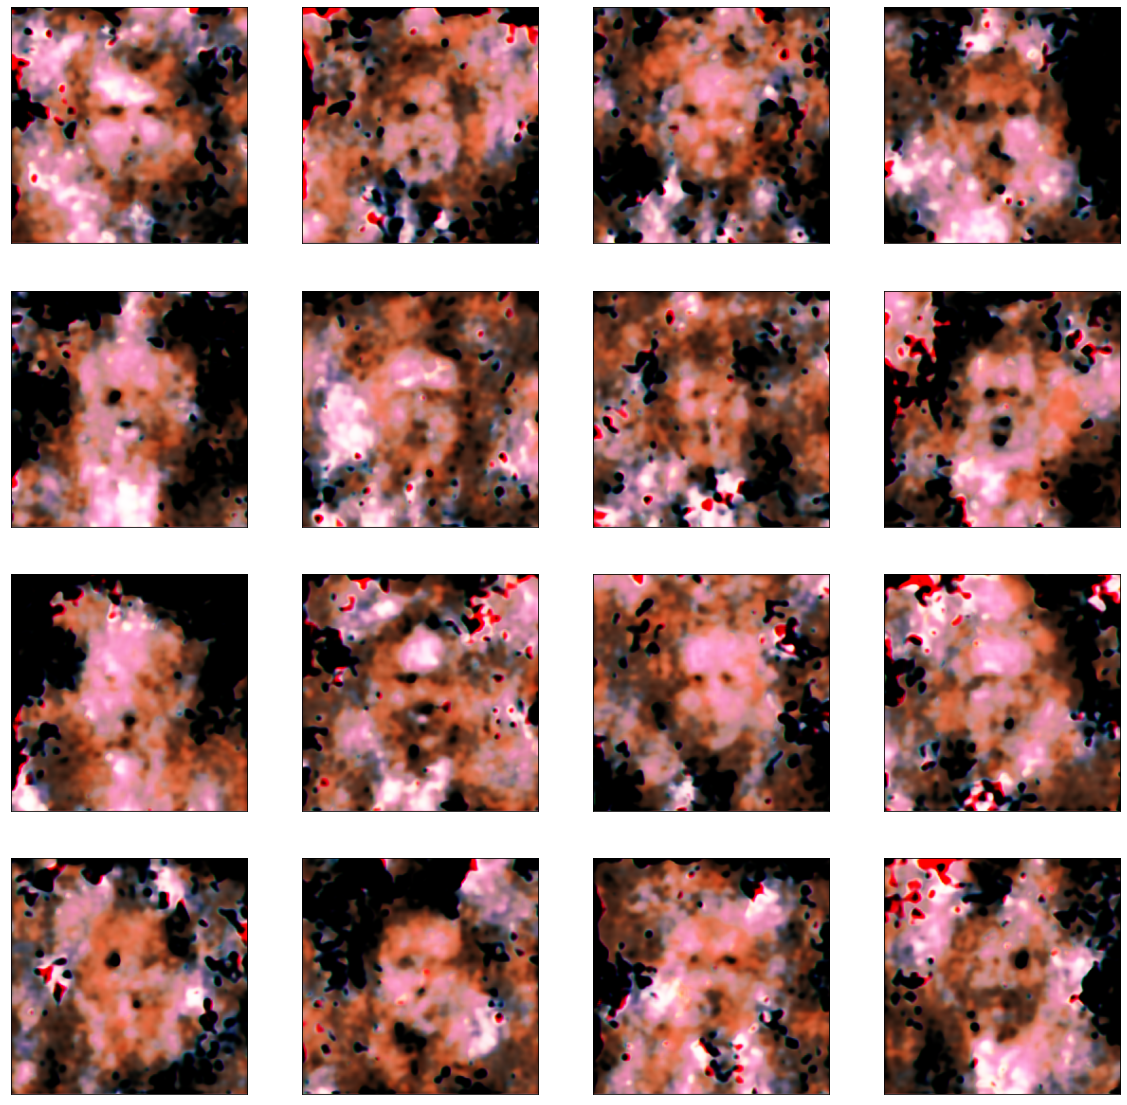

In [15]:
noise = np.random.normal(0, 1, (16, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_images(syntetic_images)

На сгенерированных изображениях наблюдаем характерные черты лиц, но изображения всё ещё далеки от реальных. Обучение модели на двух эпохах заняло почти сутки.